In [ ]:
#!pip install torch torchvision

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

In [ ]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [ ]:
batch_size = 512
epochs = 20
learning_rate = 1e-3
input_size = 128

In [ ]:
# RAM database

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

In [ ]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=64
        )
        self.encoder_hidden_layer2 = nn.Linear(
            in_features=64, out_features=32, 
        )
        self.encoder_hidden_layer3 = nn.Linear(
            in_features=32, out_features=16, 
        )
        self.encoder_output_layer = nn.Linear(
            in_features=16, out_features=32
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=32, out_features=64
        )
        self.decoder_output_layer = nn.Linear(
            in_features=64, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        activation = self.encoder_hidden_layer2(activation)
        activation = torch.relu(activation)
        activation = self.encoder_hidden_layer3(activation)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.sigmoid(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.sigmoid(activation)
        return reconstructed

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=784).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# mean-squared error loss
criterion = nn.MSELoss()

In [ ]:
for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.view(-1, input_size).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))

epoch : 1/20, recon loss = 0.08673750
epoch : 2/20, recon loss = 0.06183468
epoch : 3/20, recon loss = 0.05893534
epoch : 4/20, recon loss = 0.05157324
epoch : 5/20, recon loss = 0.04651592
epoch : 6/20, recon loss = 0.04068924
epoch : 7/20, recon loss = 0.03838152
epoch : 8/20, recon loss = 0.03653889
epoch : 9/20, recon loss = 0.03372864
epoch : 10/20, recon loss = 0.03145939
epoch : 11/20, recon loss = 0.02995572
epoch : 12/20, recon loss = 0.02911496
epoch : 13/20, recon loss = 0.02826889
epoch : 14/20, recon loss = 0.02695207
epoch : 15/20, recon loss = 0.02603359
epoch : 16/20, recon loss = 0.02529496
epoch : 17/20, recon loss = 0.02466811
epoch : 18/20, recon loss = 0.02398791
epoch : 19/20, recon loss = 0.02352843
epoch : 20/20, recon loss = 0.02316704


In [ ]:
test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=10, shuffle=False
)

test_examples = None

with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features[0]
        batch_features = batch_features.to(device)
        test_examples = batch_features.view(-1, 784)
        reconstruction = model(test_examples)
        break

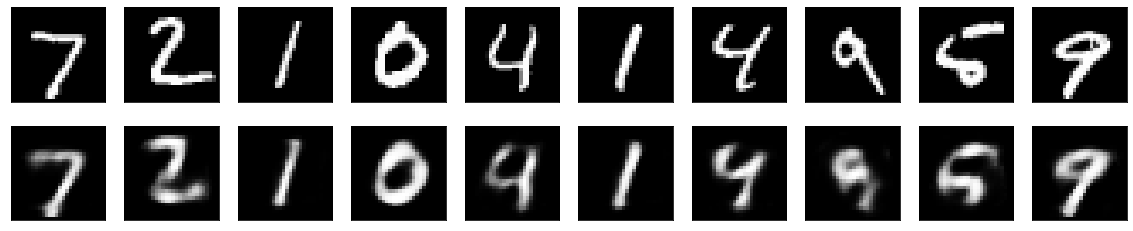

In [ ]:
with torch.no_grad():
    number = 10
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].cpu().numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index].cpu().numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()